**Before you continue**

Running a CNN on video data can be quite slow, so it is a good idea to make use of Google Colab's GPU acceleration to speed things up. To enable this, click Runtime > Change runtime type and select "GPU" as the Hardware accelerator.

Run the cell below to import modules that you are likely to need when completing the assignment.

In [ ]:
import copy
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
import scipy.optimize
import torch
import torchvision
import torchvision.transforms.functional as tvtf
import traceback
from tqdm.notebook import tqdm # Used to generate progress bars for long operations.
from typing import Union, Optional, Callable # Used for type hinting for the Visualizer module.
from google.colab import drive, files # Files is used to download the annotated videos.

In [ ]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CSE3VIS

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CSE3VIS


Run the cell below to preview the first frame from your video. If your video is called something other than `task1.mkv` (e.g. `task1.mp4`), you will need to edit the first line.

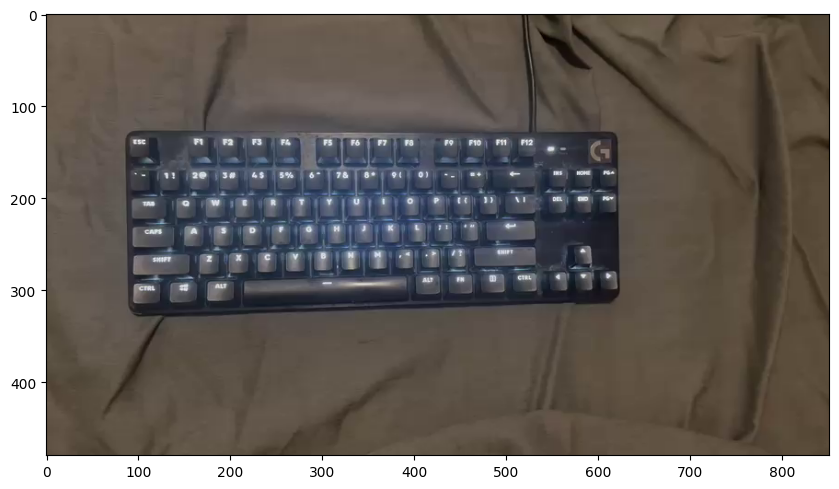

In [ ]:
#@title Question 1
filename = './task1.mov'

vid = cv2.VideoCapture(filename)
_, img = vid.read()

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)
ax.imshow(img)
fig.tight_layout()

In [ ]:
def preprocess_image(image):
    image = tvtf.to_tensor(image)
    image = image.unsqueeze(dim=0)
    return image

maskrcnn = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
maskrcnn.eval()
if torch.cuda.is_available():
    maskrcnn.cuda()

# Go to the start of the video
vid.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Record how long the video is (in frames)
vid_length = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))

# For each frame, read it, give it to maskrcnn and record the detections
all_boxes = []
all_labels = []
all_scores = []
for i in range(vid_length):
    _, img = vid.read()
    if img is None:
        break
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    with torch.no_grad():
        input_image = preprocess_image(img)
        if torch.cuda.is_available():
            input_image = input_image.cuda()
        result = maskrcnn(input_image)[0]

    all_boxes.append(result['boxes'].detach().cpu().numpy())
    all_labels.append(result['labels'].detach().cpu().numpy())
    all_scores.append(result['scores'].detach().cpu().numpy())
    if i % 20 == 0:
        print(f'{i+1:0d}/{vid_length}')

torch.save(all_boxes, 'all_boxes.pt')
torch.save(all_labels, 'all_labels.pt')
torch.save(all_scores, 'all_scores.pt')

In [ ]:
all_boxes = torch.load('all_boxes.pt')
all_labels = torch.load('all_labels.pt')
all_scores = torch.load('all_scores.pt')

vid_length = len(all_boxes)

print(f'Loaded detections for {vid_length} video frames')

Loaded detections for 976 video frames


<ipython-input-20-6aa52058e509>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_boxes = torch.load('all_boxes.pt')
<ipython-input-20-6aa52058e509>:2: FutureWarning: You

In [ ]:
#@title Solution Class

'''I wanted to try and use a more object-oriented style for this assessment, as for assessment 1 I tried to use a functional style. I also wanted to write something I could easily extend in the future, or that
  others could possibly use for similar tasks. Sorry about the very large cell, I would split it up to be more readable, but I think class definitions have to be in one cell in Jupyter Notebooks & Collab'''

class Visualizer:
    """A Visualizer object provides utilities for viewing and working with the detections of a maskrcnn model."""
    class err(Exception):
        """
        Simple utility class to wrap exceptions for the Visualizer module.
        """
        def __init__(self, msg: str="Encountered error.") -> None:
            """
            Initialize err with a message, default is "Encountered Error"
            Args:
            msg (str): The message displayed when a new err object is instantiated.
            """
            self.message: str = msg
            super().__init__(self.message)
    @staticmethod
    def handle_err(method: Callable) -> Callable:
      # Wrapper method for handling exceptions in Visualizers - handles exceptions thrown by any method decorated by @handle_err.
      # Methods in Visualizer with their own exception handling are not decorated with this function, as it is intended to handle exceptions generically.
      def enclosed( *args, **kwargs):
        try:
          return method(*args, **kwargs)
        except Exception as e:
          raise Visualizer.err(f'Exception encountered in {method.__name__}'
                               f', Stack-trace:\n {traceback.format_exc()}') from e # Also display the original exception & stacktrace
      return enclosed

    def __init__(
            self,
            source: Union[str, cv2.VideoCapture],
            boxes: Optional[list] = None,
            labels: Optional[list] = None,
            scores: Optional[list] = None,
            classes: Optional[Union[list, dict, set, np.array]] = None,
            draw_boxes: bool = True,
            draw_scores: bool = True,
            draw_labels: bool = True) -> None:
        """
        Initalize the Visualizer class with a video, optional pre-computed detections, and optional setting of bool-flags to control video annotation.
        Args:
            source - The str path to a video or a cv2.VideoCapture object - this is the video annotations and data will be collected from.
            boxes - A list of detected bounding boxes for objects found in source - if None, boxes is set to an empty list.
            labels - A list of detected labels for objects found in source - if None, labels is set to an empty list.
            scores - A list of detected object scores for objects found in source - if None, scores boxes is set to an empty list.
            classes - Sequence like object containing indices of classes/labels you are interested in tracking - can also be a dict with values equal to the,
            desired confidence threshold for each label. If None, all labels from source will be tracked, rather than just those specified in classes.
            draw_boxes - boolean, determines if bounding boxes are tracked and drawn in the annotate_video method.
            draw_scores - boolean, determines if object detection scores are tracked and drawn in the annotate_video method.
            draw_labels - boolean, determines if labels are tracked and drawn in the annotate_video method.
        """
        self.video: cv2.VideoCapture = cv2.VideoCapture(source) if isinstance(source, str) else source # Handle both paths to videos and pre-loaded cv2.VideoCapture objects.
        if not self.video.isOpened():
            raise ValueError("Err Opening") # Raise a ValueError if opening the video fails
        # boxes, labels, and scores are set to the provided values if pre-computed detections are passed in, otherwise they are set to None.
        self.boxes: list = boxes if boxes is not None else []
        self.labels: list = labels if labels is not None else []
        self.scores: list = scores if scores is not None else []
        self.num_frames: int = int(self.video.get(cv2.CAP_PROP_FRAME_COUNT)) # Total number of frames found in source

        # Sequence like list of labels we are interested in - if provided, labels not found in self.classes will be ignored, if not provided, all labels will be tracked and considered 'interesting'
        self.classes: dict = self.instantiate_classes(classes) if classes else {}
        self.detection_map: dict = {} # Dictionary where each key is the frame index of source at a given frame and the values are nested dictionaries of class labels to scores at that frame.
        self.empty_frames: int = 0 # Tracks how many 'uninteresting' frames there are in source - that is, frames without detecting any of the labels we are interested in.
        self.tracking_data: dict = {label: [] for label in classes or []} if self.classes else {} # Records tracking data across frames for each label we are interested in.
        # boolean flags used to determine what is annotated when annotate_video is called - by default, boxes, scores, and labels will all be annotated onto the video.
        self.draw_boxes: bool = draw_boxes
        self.draw_scores: bool = draw_scores
        self.draw_labels: bool = draw_labels

    @staticmethod
    @handle_err
    def instantiate_classes(classes: dict) -> dict:
        """
        Cast a sequence like object of class labels into a label: confidence_threshold dictionary, the default threshold value is 0.6 if threshold values are not provided.
        Args:
            classes - Sequence-like collection of class indices for maskrcnn.
        Returns:
               Dict of class confidence_threshold pairs.
        """
        if isinstance(classes, dict):
            return classes # If classes is already a dictionary, return it in place.
        # Otherwise, use a dict comprehension to convert classes to a dictionary, with default values for confidence_threshold.
        if isinstance(classes, (list, set, np.array)):
            return {key: 0.6 for key in classes} # The default confidence_threshold assigned is 0.6
        raise TypeError("Classes must be sequence-like or dict.") # If we haven't returned yet, raise a TypeError.

    @handle_err
    def get_colors(self) -> list:
        """This is straightfowardly the COLOURS list comprehension from lab 04, decomposed into atomic functions.
           When @handle_err is used to decorate a closure, enclosed functions that throw exceptions will have thier exceptions
           propagate up to the outermost function, where they will be handled by the decorater.In effect, decorating the outermost
           function, also implicitly decorates any nested functions. """
        def convert_hex_to_rgb(hex_code) -> tuple:
            return tuple (
                int(hex_code.lstrip('#')[i:i+2], 16) for i in range (0, 2, 4)
            )
        def get_color_cycle():
            return plt.rcParams['axes.prop_cycle'].by_key()['color']
        return [convert_hex_to_rgb(color) for color in get_color_cycle()]

    @handle_err
    def draw_detections(self,
                        img: np.array,
                        detection: np.array,
                        labels: Union[np.array, list, None],
                        scores: Union[np.array, list],
                        frame_idx: int,
                        colors: list) -> None:
        """Helper function that performs the actual video annotation within atomically_process_frame.
         Args:
             img: The frame at a given step represented as a numpy array.
             detection: The bounding box coordinates for detected object at frame_idx - (tlx, tly, brx, bry)
             labels: The labels for the classes we are interested in detecting, if None we annotate ALL detected classes,
             found in the frame that meet the confidence threshold.
             scores: Confidence scores for each detected label/object.
             frame_idx: The index of the frame being annotated.
             colors: List of RGB values.
         """
        frame_detections: dict = {} # Detections at frame (frame_idx) - used to populate self.detection_map.
        uninteresting_frame: bool = True # Number of frames with no detections of interest.
        def write_text(img, text, postion, color) -> None: # Enclosed helper function for writing the scores and labels (and/or any text) to the frame.
            cv2.putText(img, text, postion, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, color, 2)
        # Iterate over all detections in the frame
        for i, ((tlx, tly, brx, bry), label, score) in enumerate(zip(detection, labels, scores)):
            if self.classes and label not in self.classes: # If provided specific class labels we are interested in, and the current label isn't one of them,
                continue # Skip this iteration
            # If not provided any class labels OR the confidence score is greater or equal to the confidence threshold attached to the label as a value in the classes dict:
            if not self.classes or score >= self.classes.get(label):
                # Select a color and annotate the frame, based on the status of the class-level 'draw_x' flags
                color = colors[i % len(colors)]
                uninteresting_frame = False # If we found detections we are interested in for this frame, set uninteresting_frame to False.
                if self.draw_boxes:
                    cv2.rectangle(img, (tlx, tly), (brx, bry), color=color, thickness=2)
                if self.draw_labels:
                    write_text(img, f'{label}', (tlx, tly - 10), color=color)
                if self.draw_scores:
                    write_text(img, f'{score:.3f}', (brx, bry + 5), color=color)
                frame_detections[label] = score # Add the score for the current label to the frame_detections map.
            if uninteresting_frame:
              self.empty_frames += 1 # If we didn't find any detections we are interested in, increment the count of empty frames.
        self.detection_map[frame_idx] = frame_detections # Add the frame_detections dictionary as a value keyed to this frame for the detection_map dict.

    @handle_err
    def atomically_process_frame(self, computing_thresholds: bool, frame_idx: int, colors: list) -> None:
        """Process and optionally display detections for a single frame - I focused on atomising this operation, as well
        as compute_atomic_iou to enable parallelisation, unfortunately in Google Collab, that invariably caused the kernel to crash.
        Args:
            computing_thresholds - boolean that determines if processed frames are displayed or not - for big operations parsing every frame, this should be False.
            frame_idx - Index of the current frame being processed.
            colors - list of color tuples
        """
        self.video.set(cv2.CAP_PROP_POS_FRAMES, frame_idx) # Set the video to the frame_idx frame
        _, frame = self.video.read()
        if frame is None:
            print(f"empty frame at {frame_idx}")
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Color the frame to RGB
        # Access the boxes, labels, and scores for this frame if they were provided at class instantiation, otherwise pass None to draw_detections().
        current_boxes: np.array = self.boxes[frame_idx].astype(np.int32) if self.draw_boxes else None
        current_labels: list = self.labels[frame_idx] if self.draw_labels else None
        current_scores: list = self.scores[frame_idx] if self.draw_scores else None
        self.draw_detections(frame, current_boxes, current_labels, current_scores, frame_idx, colors) # Call helper method to annotate the frame.
        if not computing_thresholds: # If we are considering only a few frames (i.e for large step values) display each frame as its processed.
            plt.title(f'Detections at frame {frame_idx}/{self.num_frames}')
            plt.imshow(frame)
            plt.axis('off')
            plt.show()
            plt.clf()

    @handle_err
    def annotate_video(self,
                       step: int = 61,
                       computing_thresholds: bool = False,
                       desc: str = None,
                       track: bool = False,
                       iou_threshold: float = 0.5,
                       name: str ='overlayed.mp4',
                       download: bool = False):
        """Annotate detections onto a video or subset of frames.
          Args:
              step - Distance between each frame, i.e a step of 20 will annotate every 20th frame, or a step of 1 will annotate every frame,
              by default 61 as 61 is a large divisor of the number of frames in my video (976)
              computing_thresholds - Boolean that determines if we display each frame as its processed - named as when computing dynamic thresholds, displaying every frame is encumbering.
              desc - Description to display for the progress bar.
              track - Boolean that determines if tracking based on IoU is performed.
              name - The desired name for the produced video, if download is True.
              iou_threshold - Threshold value for IoU when matching objects across frames, by default 0.5.
              download - Boolean flag to determine if annotated videos should be automatically downloaded.
          Implementation adjusted from Labs 4 & 7.
        """
        if any(self.tracking_data[label] for label in self.tracking_data):
            """Tracking data for objects persists between runs within self.tracking_data.
               Check if any key in self.tracking_data has content - if so, data from prior runs is currently stored.
               Clear the previous data to correctly & cleanly store tracking data for new runs.
            """
            print("Tracking data from previous run found...")
            print("Clearing tracking data from previous run...")
            self.tracking_data = {label: [] for label in self.classes or []} if self.classes else {} # Create new empty lists for each label to store fresh tracking data in.
        colors: list = self.get_colors()
        if not name.endswith('.mp4'):
          name += ".mp4" # Append .mp4 to video titles that don't feature it.
        if track:
            width, height, fps = map(int, (self.video.get(prop) for prop in (
                cv2.CAP_PROP_FRAME_WIDTH,
                cv2.CAP_PROP_FRAME_HEIGHT,
                cv2.CAP_PROP_FPS,
            ))) # Tuple comprehension gets the width, height, and FPS for the video, which are all converted to ints using map.
            writer = cv2.VideoWriter_fourcc(*'mp4v')
            writer = cv2.VideoWriter(name, writer, fps, (width, height)) # Create a video writer with the retrieved video data.
            for i in tqdm(range(self.num_frames), desc="Overlaying tracking information..."): # Wrap this loop in tqdm to display a progress bar.
                matches = self.compute_atomic_iou(i, iou_threshold) # Find the IoU matches for this frame.
                if not matches: # Skip this iteration if no matches are found.
                    continue
                self.video.set(cv2.CAP_PROP_POS_FRAMES, i) # Set the video to the current frame.
                _, frame = self.video.read()
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                curr_match = [a for a, _ in matches] # Get the indexes of boxes in the current frame that have matches in the prior frame.
                #  Index into each of these lists/np.arrays using the indices of matched objects from the current frame, while also ensuring that box values are 32 bit integers as required by OpenCV.
                curr_box: np.array = self.boxes[i][curr_match].astype(np.int32)
                labels: np.array = self.labels[i][curr_match]
                scores: np.array = self.scores[i][curr_match]
                self.draw_detections(frame, curr_box, labels, scores, i, colors) # Annotate the current frame
                annotated = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                writer.write(annotated) # Write the current frame to the annotated video being created.
            writer.release()
            print(f"Created annotated video, filename: {name}")
            if download:
              print(f"Downloading annotated video...")
              try:
                files.download(name)
              except:
                print(f"Failed to download file: {name}")
        else: # If we aren't tracking, annotate a frame every {step} frames
            desc: str = f"Annotating frames with a step of {step}" if not desc else desc # Default progress bar message
            frames_to_process = range(0, self.num_frames, step) # Range expression and step value selects the frames to be annotated.
            for i in tqdm(frames_to_process, desc=desc): # Wrap this operation in tqdm to load a progress bar.
                self.atomically_process_frame(frame_idx=i, colors=colors, computing_thresholds=computing_thresholds)
            self.detection_map[None] = self.empty_frames # After we have the count of 'uninteresting' frames, store it in the detection map under the special key None.

    @handle_err
    def set_dynamic_thresholds(self, initial_threshold: float = 0.7) -> None:
        """Dynamically compute optimal confidence thresholds using the formula for determining the expected value of a Beta distribution:
           E(X) = (α / α + β) - in this implementation I added a smoothing constant 2, thus the true formula implemented is
           E(X̄) = (α / α + β + 2) - where α corresponds to the number of positive samples (samples where the confidence score of a label meets or exceeds the initial_threshold),
           β represents the number of negative samples (where said threshold is not exceeded), and 2 is a smoothing constant, that aims to account for the skew of the distribution.
           https://statproofbook.github.io/P/beta-mean.html
           Args:
               initial_threshold - An initial value, where confidence scores greater than or equal to this value are considered 'positive' samples.
        """
        # Populate the detection map with detections across all frames using annotate video with computing_thresholds set to True.
        self.annotate_video(step=1,
                           computing_thresholds=True,
                           desc=f"Computing dynamic thresholds across all {self.num_frames} frames with initial threshold {initial_threshold}...."
                           )
        """Across all detections, across all frames, extract every label (avoiding extracting the None label we keyed to uninteresting frames)
           For each frame, assign them as a key in a dictionary, with a value of (1, 1) - this reflects an initial uncertainty about the likelihood of each
           label's confidence score exceeding the initial threshold in a frame. """
        prior_probablities: dict = {
            label: (1, 1)
            for frame in self.detection_map.values()
            if isinstance(frame, dict)
            for label in frame
        }
        def increment_prior(label: int, score: float) -> None:
            """Helper function to increment the relevant prior in each possible case - if the labels confidence score in the given step
            exceeds the initial_threshold, increment the count of 'positive' samples encountered, otherwise increment the count of 'negative' samples.
            Args:
                label - The indice/label of the class currently being evaluated.
                score - The confidence score of the given class in this step."""
            prior_probablities[label] = (
                prior_probablities[label][0] + 1 if score >= initial_threshold else prior_probablities[label][0],
                prior_probablities[label][1] + 1 if score < initial_threshold else prior_probablities[label][1],
            )
        def update_priors(frame: dict) -> None:
            # Update priors for each label found in the current frame.
            if not isinstance(frame, dict):
                return
            for label, score in frame.items():
                increment_prior(label, score) # Call enclosed helper function.
        for frame in self.detection_map.values():
            update_priors(frame) # The outermost function, set_dynamic_thresholds calls update_priors for each frame in the detection_map, which calls increment_priors on each of these frames.
        # Create a dictionary of the dynamic thresholds found for each label using a dictionary comprehension and the aforementioned formula.
        # Add 2 as a smoothing term to account for the high number of high-scoring or 'positive' samples.
        optimal_thresholds = {
            label: alpha / (alpha + beta + 2)
            for label, (alpha, beta)
            in prior_probablities.items()
        }
        self.classes.update(optimal_thresholds) # Update the dictionary of labels and confidence thresholds with the newly computed thresholds.

    @handle_err
    def set_percentile_thresholds(self, percentile: int = 80) -> None:
        # Find the cut-off for the percentile (default = 80) set of confidence_scores for each label.
        # Flatten the nested lists of scores and labels across all frames with numpy.
        flat_labels = np.concatenate(self.labels).flatten()
        flat_scores = np.concatenate(self.scores).flatten()
        """Find the top percentile of scores for each label - achieved with the boolean mask flat_labels == label, which filters out the flat_scores array to consist soley of scores for that label,
         for each label in the comprehension. These values are used to generate a new dictionary of label confidence_threshold pairs, which is stored in self.classes. """
        self.classes = {
            label: np.percentile(flat_scores[flat_labels == label], percentile)
            for label in set(flat_labels)
        }

    def compute_atomic_iou(self, frame_idx: int, iou_threshold: float) -> Union[None, tuple, np.array]:
        """ Compute the IoU matrix for bounding boxes between current and previous steps. Find the matches
            where the calculated iou is >= iou_threshold.
            Args:
                frame_idx - Index of the current frame.
                iou_threshold - Threshold for IoU values - values >= than this threshold are considered matches.
            Returns:
                    Matched indices between steps.
                    The IoU matrix.
                    (None, None) in cases of failure or no matches.
                    """
        try:
          # Get the boxes and labels from frame_idx and frame_idx - 1
          current_boxes, current_labels = self.boxes[frame_idx], self.labels[frame_idx]
          prior_boxes, prior_labels = self.boxes[frame_idx - 1], self.labels[frame_idx - 1]

        except (IndexError, ValueError): # Catch and handle index errors, for example on the first frame of the video, where frame_idx - 1 does not exist.
            return None, None

        matrix = self.bbox_iou_matrix(np.array(current_boxes), np.array(prior_boxes)) # Call the helper function from lab 7.

        """For each possible pair across the 0th and 1st dimension of the IoU matrix, if the iou score is >= iou_threshold, and they
           have matching labels - add them to the list of tuples of matching indices this expression generates. The last condition
           is a hacky way of achieving side-effects within this list comprehension - the update_tracking data helper function is called,
           and as it returns None, the or condition will evaluate the other operand to determine if the current tuple should be added to the
           list - as this expression is just True, this line will always evaluate to True, and the tuple will always be added.
           """
        matches = [
            (a, b) for a in range(matrix.shape[0])
                   for b in range(matrix.shape[1])
                   if matrix[a, b] >= iou_threshold
                   and current_labels[a] == prior_labels[b] # The check that labels match across steps ensures independent object tracking
                   and (self.update_tracking_data(current_labels[a], frame_idx, current_boxes[a]) or True)
        ]
        return matches

    @handle_err
    def update_tracking_data(self, label: list, frame_idx: int, box: np.array) -> None:
        # Update tracking data - stores the bounding box coordinates for the given label.
        if label not in self.tracking_data: # Add the label to the tracking dict if it hasn't yet been encountered.
            self.tracking_data[label] = []
        self.tracking_data[label].append((frame_idx, box)) # Update the tracking data dictionary.


    @staticmethod
    @handle_err
    def bbox_iou_matrix(a, b):
        # Implementation from lab 7
        a = a[:, None]
        b = b[None, :]
        tlx_a, tly_a, brx_a, bry_a = [a[..., i] for i in range(4)]
        tlx_b, tly_b, brx_b, bry_b = [b[..., i] for i in range(4)]
        tlx_overlap = np.maximum(tlx_a, tlx_b)
        tly_overlap = np.maximum(tly_a, tly_b)
        brx_overlap = np.minimum(brx_a, brx_b)
        bry_overlap = np.minimum(bry_a, bry_b)
        intersection = (brx_overlap - tlx_overlap).clip(0) * (bry_overlap - tly_overlap).clip(0)
        area_a = abs((brx_a - tlx_a) * (bry_a - tly_a))
        area_b = abs((brx_b - tlx_b) * (bry_b - tly_b))
        union = area_a + area_b - intersection
        return intersection / union

In [ ]:
#@title Question 2.

# Filtering the detections from the video.
filtered_classes = [1, 44, 62, 48, 69, 74, 76, 90, 72, 84] # Visualizers can take list as well as dict input - if a list/set is provided, the threshold for all labels will be set 0.6
                                                           # This produces unoptimal results, so I use the thresholds determined by hand below

# Note that I use the TV class (72) to detect my monitors, in this context the distinction seems academic.
byhand_assignments = {1: 0.9, 44: 0.7, 62: 0.99, 48: 0.4, 69: 0.7, 74: 0.7, 76: 0.6, 90: 0.3, 72: 0.8, 84: 0.85} # Selecting individual confidence thresholds to prune bad detections.


# Create a new Visualizer object to solve the assignment - load the detections generated in the given code.
solver = Visualizer(source=vid, boxes=all_boxes, labels=all_labels, scores=all_scores, classes=byhand_assignments)

solver.annotate_video() # Annotating every 61st frame.
#solver.annotate_video(step=1, computing_thresholds=True) # If you wanted to annotate every frame.

NameError: name 'Visualizer' is not defined

In [ ]:
#@title Question 3.

"""Applying object tracking to the detections in the video using IoU. Matches are only considered valid if the labels for the object across both frame and (frame - 1) are the same,
ensuring independant tracking of objects. However, if the detections group up objects in a given frame and consider for example, the book and the toothbrush as belonging to one 'book' object, with
the generated bounding box grouping both of them, both objects may be tracked as one object. This is a fault of the detections and the fallibility of maskrcnn.
"""

tracker_with_hand_assignments = Visualizer(source=vid, boxes=all_boxes, labels=all_labels, scores=all_scores, classes=byhand_assignments)
tracker_with_hand_assignments.annotate_video(track=True, download=True) # This produces a new video with tracking overlayed using IoU.
                                                                         # Set download to True to download a local copy of the generated video.

Overlaying tracking information...:   0%|          | 0/976 [00:00<?, ?it/s]

Created annotated video, filename: overlayed.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Question 3 cont.
# Experimenting with different methods of optimization for confidence score thresholds for each class to improve tracking results
# As my video is unlabeled, the optimization techniques I tried were statistical in nature and did not require knowledge of ground truth.

experimental_solver = Visualizer(source=vid, boxes=all_boxes, labels=all_labels, scores=all_scores, classes=filtered_classes)
# Method 1 - Computing dynamic thresholds using the expected value of a beta distribution
# (Assumes the distribution of each classes confidence scores can be modelled using a beta distribution.)

experimental_solver.set_dynamic_thresholds()
experimental_solver.annotate_video(track=True, download=True, name="dynamic") # Viewing the results, set download to True to automatically download the generated videos.

# Method 2 - Use the (percentile) confidence score as the threshold, by default percentile = 80

percentile_solver = Visualizer(source=vid, boxes=all_boxes, labels=all_labels, scores=all_scores, classes=filtered_classes)
percentile_solver.set_percentile_thresholds()
percentile_solver.annotate_video(track=True, download=True, name="percentile") # Viewing the results

# Effect on peformance is discussed in report.

Computing dynamic thresholds across all 976 frames with initial threshold 0.7....:   0%|          | 0/976 [00:…

Overlaying tracking information...:   0%|          | 0/976 [00:00<?, ?it/s]

Created annotated video, filename: dynamic.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Overlaying tracking information...:   0%|          | 0/976 [00:00<?, ?it/s]

Created annotated video, filename: percentile.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>